In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


In [3]:
from model import Unet

In [4]:
class SegData(Dataset):

    def __init__(self,image_paths,mask_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index]).convert('RGB')
        mask = Image.open(self.mask_paths[index]).convert('L')

        image = np.array(image)
        mask = np.array(mask)

        image = np.transpose(image,(2,0,1))

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(image,0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (256,256)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (256,256)),
            transforms.Lambda(lambda x: x/torch.max(x)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        image = image.squeeze()
        mask = mask.squeeze()

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
        
        sample = {'image':image,'mask':mask}

        return sample

In [5]:
data_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
data_fold = [x.name for x in os.scandir(data_dir) if x.is_dir()]
data_fold.remove('.ipynb_checkpoints')

total_input_files = []
total_output_files = []
for fold in data_fold:
    fold_dir = os.path.join(data_dir,fold)
    for subfold in [x.name for x in os.scandir(os.path.join(data_dir,fold)) if (x.is_dir and x.name[0]!='.' and x.name!='Thumbs.db')]:
        subfold_dir = os.path.join(fold_dir,subfold)
        if subfold == 'images':
            total_input_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])
        elif subfold == 'masks':
            total_output_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])

In [6]:
# h_img,w_img = Image.open(total_input_files[0]).convert('RGB').size
# #get normalization values for the complete dataset
# red_sum = 0
# # blue_sum = 0
# # green_sum = 0
# # because orignal data is grey scale so values are distributed evenly across all three channels.
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = np_image[:,:,0].flatten()
#     # green_values = np_image[:,:,1].flatten()
#     # blue_values = np_image[:,:,2].flatten()

#     red_sum += np.sum(red_values)
#     # blue_sum += np.sum(blue_values)
#     # green_sum += np.sum(green_values)

#     del(red_values)
#     # del(green_values)
#     # del(blue_values)

# total_mean = [red_sum/(h_img*w_img*len(total_input_files))]*3

# red_std_sum = 0
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = (np_image[:,:,0].flatten() - total_mean[0])**2
#     red_std_sum += np.sum(red_values)

#     del(red_values)

# total_std = [math.sqrt(red_std_sum/(h_img*w_img*len(total_input_files)))]*3

In [7]:
from tqdm import tqdm

In [8]:
import gc

In [9]:
def train():

    seed = 13
    torch.manual_seed(seed)
    best_v_loss = 1_000_000

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    
    model = Unet(3,1)
    model.to(device)
    epochs = 10
    loss_func = torch.nn.BCEWithLogitsLoss()
    loss_func.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor = 0.8,min_lr=1e-6)
    pth = os.getcwd()
    model_path = os.path.join(pth,'model_1')
    log_dir = os.path.join(model_path,'runs')
    wts_path = os.path.join(model_path,'weigths')

    if os.path.exists(model_path) == False:
        os.mkdir(model_path)
        
        os.mkdir(log_dir)
        
        os.mkdir(wts_path)
    
    writer = SummaryWriter(log_dir=log_dir)

    #splitting the dataset into traininig and validation set
    train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=seed)
    train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    train_dataloader = DataLoader(train_data,batch_size = 4,shuffle = True,pin_memory = True)
    valid_dataloader = DataLoader(valid_data,batch_size = 4,shuffle = False,pin_memory = True)

    #print("After Model to device : ",torch.cuda.memory_allocated(device)/(1024*1024))
    for e in tqdm(range(epochs)):

        #training the model 
        print('Epoch {0}'.format(e+1))
        epoch_loss = 0.0
        run_loss = 0.0
        model.train(True)

        for i,batch in enumerate(train_dataloader):
            
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
    
            #print(batch['image'].shape)
            v_img = transforms.RandomVerticalFlip(p=1)(image)
            h_img = transforms.RandomHorizontalFlip(p=1)(image)
            r_img = transforms.RandomRotation(degrees=(-25,25))(image)
            image_final = torch.cat((image,v_img,h_img,r_img),0)

            #print(image_final.shape)
                    
            v_mask = transforms.RandomVerticalFlip(p=1)(mask)
            h_mask = transforms.RandomHorizontalFlip(p=1)(mask)
            r_mask = transforms.RandomRotation(degrees=(-25,25))(mask)
            mask_final = torch.cat((mask,v_mask,h_mask,r_mask),0)
            mask_final = torch.unsqueeze(mask_final,1)
            #print(mask_final.shape)
            
#             image_final.to(device)
#             mask_final.to(device)
            
#             print(image_final.dtype)
#             print(mask_final.dtype)
#             print(device)
            #a = torch.cuda.memory_allocated(device)/(1024*1024)
            optimizer.zero_grad()
            pred = model.forward(image_final)
            #print("after forward pass", torch.cuda.memory_allocated(device)/(1024*1024))
            #b = torch.cuda.memory_allocated(device)/(1024*1024)
            #print("memory consumed by forward_pass",b-a)
            loss = loss_func(pred,mask_final)
            

            run_loss = run_loss + loss.item()
            epoch_loss = epoch_loss + loss.item()
            
            loss.backward()
            #print("memory after backward pass ", torch.cuda.memory_allocated(device)/(1024*1024))
            optimizer.step()
            #print("memory after optimizer ",torch.cuda.memory_allocated(device)/(1024*1024))

            #print('the current loss is {0}'.format(run_loss))
            
#             del mask_final
#             del image_final
#             del pred
#             del v_img
#             del h_img
#             del r_img
#             del v_mask
#             del h_mask
#             del r_mask
#             del mask
#             del image
            
            #print("memory after delete ",torch.cuda.memory_allocated(device)/(1024*1024))
            

            if(i%100 == 99):
                
#                 for obj in gc.get_objects():
#                     try:
#                         if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obg.data)):
#                             print(type(obj),obj.size())
#                     except:
#                         pass
                

                print("\tBatch Loss for curent for {0} is {1:.5f}".format(i,run_loss/100))
                run_loss = 0.0
                

        avg_e_loss = epoch_loss/(i+1)
        print('The average loss for the epoch is {0}'.format(avg_e_loss))

        #validating the model
        model.train(False)

        val_loss = 0.0

        for k,batch in enumerate(valid_dataloader):
            final_image = batch['image'].to(device)
            final_mask = torch.unsqueeze(batch['mask'],1).to(device)

            pred = model.forward(final_image)
            loss = loss_func(pred,final_mask)

            val_loss+= loss.item()
            
#             del final_image
#             del final_mask
#             break
        
        

        avg_val_loss = val_loss/(k+1)
        print('The average validation loss for the epoch is {0:.5f}'.format(avg_val_loss))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_e_loss, 'Validation' : avg_val_loss },
                    e)
        
        if avg_val_loss < best_v_loss:

            best_v_loss = avg_val_loss
            best_wt_path = os.path.join(wts_path,'best_epoch'+str(e))
            

        writer.flush()
        

        #break
        wt_path =  os.path.join(wts_path,'epoch_'+str(e))
        torch.save(model.state_dict(), wt_path)
    torch.save(model.state_dict(), best_wt_path)

In [10]:
train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
	Batch Loss for curent for 99 is 0.36346
	Batch Loss for curent for 199 is 0.22554
	Batch Loss for curent for 299 is 0.19245
	Batch Loss for curent for 399 is 0.16505
	Batch Loss for curent for 499 is 0.17013
	Batch Loss for curent for 599 is 0.15443
	Batch Loss for curent for 699 is 0.15416
	Batch Loss for curent for 799 is 0.13229
	Batch Loss for curent for 899 is 0.12623
	Batch Loss for curent for 999 is 0.13943
	Batch Loss for curent for 1099 is 0.12902
	Batch Loss for curent for 1199 is 0.12145
	Batch Loss for curent for 1299 is 0.12824
	Batch Loss for curent for 1399 is 0.11913
	Batch Loss for curent for 1499 is 0.11274
	Batch Loss for curent for 1599 is 0.11257
	Batch Loss for curent for 1699 is 0.10714
	Batch Loss for curent for 1799 is 0.10096
	Batch Loss for curent for 1899 is 0.09729
	Batch Loss for curent for 1999 is 0.12370
	Batch Loss for curent for 2099 is 0.10442
	Batch Loss for curent for 2199 is 0.09801
	Batch Loss for curent for 2299 is 0.10535
	Batch Loss fo

 10%|█         | 1/10 [30:51<4:37:45, 1851.77s/it]

Epoch 2
	Batch Loss for curent for 99 is 0.08013
	Batch Loss for curent for 199 is 0.07582
	Batch Loss for curent for 299 is 0.08136
	Batch Loss for curent for 399 is 0.07564
	Batch Loss for curent for 499 is 0.08039
	Batch Loss for curent for 599 is 0.07734
	Batch Loss for curent for 699 is 0.07751
	Batch Loss for curent for 799 is 0.07674
	Batch Loss for curent for 899 is 0.08675
	Batch Loss for curent for 999 is 0.08235
	Batch Loss for curent for 1099 is 0.07746
	Batch Loss for curent for 1199 is 0.07400
	Batch Loss for curent for 1299 is 0.07867
	Batch Loss for curent for 1399 is 0.07678
	Batch Loss for curent for 1499 is 0.07972
	Batch Loss for curent for 1599 is 0.08377
	Batch Loss for curent for 1699 is 0.07185
	Batch Loss for curent for 1799 is 0.07423
	Batch Loss for curent for 1899 is 0.07591
	Batch Loss for curent for 1999 is 0.07143
	Batch Loss for curent for 2099 is 0.07752
	Batch Loss for curent for 2199 is 0.07212
	Batch Loss for curent for 2299 is 0.07506
	Batch Loss fo

 20%|██        | 2/10 [1:01:32<4:06:01, 1845.23s/it]

Epoch 3
	Batch Loss for curent for 99 is 0.06967
	Batch Loss for curent for 199 is 0.06954
	Batch Loss for curent for 299 is 0.06787
	Batch Loss for curent for 399 is 0.06773
	Batch Loss for curent for 499 is 0.06786
	Batch Loss for curent for 599 is 0.06937
	Batch Loss for curent for 699 is 0.06920
	Batch Loss for curent for 799 is 0.07013
	Batch Loss for curent for 899 is 0.07162
	Batch Loss for curent for 999 is 0.07028
	Batch Loss for curent for 1099 is 0.06821
	Batch Loss for curent for 1199 is 0.06916
	Batch Loss for curent for 1299 is 0.06578
	Batch Loss for curent for 1399 is 0.06560
	Batch Loss for curent for 1499 is 0.06956
	Batch Loss for curent for 1599 is 0.07134
	Batch Loss for curent for 1699 is 0.06637
	Batch Loss for curent for 1799 is 0.06341
	Batch Loss for curent for 1899 is 0.06502
	Batch Loss for curent for 1999 is 0.08571
	Batch Loss for curent for 2099 is 0.08339
	Batch Loss for curent for 2199 is 0.07004
	Batch Loss for curent for 2299 is 0.06968
	Batch Loss fo

 30%|███       | 3/10 [1:32:11<3:34:56, 1842.42s/it]

Epoch 4
	Batch Loss for curent for 99 is 0.06337
	Batch Loss for curent for 199 is 0.06507
	Batch Loss for curent for 299 is 0.06391
	Batch Loss for curent for 399 is 0.06646
	Batch Loss for curent for 499 is 0.06813
	Batch Loss for curent for 599 is 0.06892
	Batch Loss for curent for 699 is 0.06632
	Batch Loss for curent for 799 is 0.06082
	Batch Loss for curent for 899 is 0.06185
	Batch Loss for curent for 999 is 0.06373
	Batch Loss for curent for 1099 is 0.06603
	Batch Loss for curent for 1199 is 0.06124
	Batch Loss for curent for 1299 is 0.06481
	Batch Loss for curent for 1399 is 0.06226
	Batch Loss for curent for 1499 is 0.06989
	Batch Loss for curent for 1599 is 0.06332
	Batch Loss for curent for 1699 is 0.06886
	Batch Loss for curent for 1799 is 0.06476
	Batch Loss for curent for 1899 is 0.06516
	Batch Loss for curent for 1999 is 0.06332
	Batch Loss for curent for 2099 is 0.06460
	Batch Loss for curent for 2199 is 0.06291
	Batch Loss for curent for 2299 is 0.06226
	Batch Loss fo

 40%|████      | 4/10 [2:02:53<3:04:13, 1842.27s/it]

Epoch 5
	Batch Loss for curent for 99 is 0.06219
	Batch Loss for curent for 199 is 0.06005
	Batch Loss for curent for 299 is 0.05841
	Batch Loss for curent for 399 is 0.06254
	Batch Loss for curent for 499 is 0.06200
	Batch Loss for curent for 599 is 0.06415
	Batch Loss for curent for 699 is 0.06228
	Batch Loss for curent for 799 is 0.06500
	Batch Loss for curent for 899 is 0.05941
	Batch Loss for curent for 999 is 0.06076
	Batch Loss for curent for 1099 is 0.06314
	Batch Loss for curent for 1199 is 0.06400
	Batch Loss for curent for 1299 is 0.06376
	Batch Loss for curent for 1399 is 0.06374
	Batch Loss for curent for 1499 is 0.05976
	Batch Loss for curent for 1599 is 0.06114
	Batch Loss for curent for 1699 is 0.06166
	Batch Loss for curent for 1799 is 0.06342
	Batch Loss for curent for 1899 is 0.06802
	Batch Loss for curent for 1999 is 0.06112
	Batch Loss for curent for 2099 is 0.06030
	Batch Loss for curent for 2199 is 0.05843
	Batch Loss for curent for 2299 is 0.06339
	Batch Loss fo

 50%|█████     | 5/10 [2:33:30<2:33:21, 1840.37s/it]

Epoch 6
	Batch Loss for curent for 99 is 0.05729
	Batch Loss for curent for 199 is 0.06291
	Batch Loss for curent for 299 is 0.05761
	Batch Loss for curent for 399 is 0.06037
	Batch Loss for curent for 499 is 0.05853
	Batch Loss for curent for 599 is 0.05846
	Batch Loss for curent for 699 is 0.05874
	Batch Loss for curent for 799 is 0.05974
	Batch Loss for curent for 899 is 0.06052
	Batch Loss for curent for 999 is 0.06089
	Batch Loss for curent for 1099 is 0.05919
	Batch Loss for curent for 1199 is 0.05859
	Batch Loss for curent for 1299 is 0.06013
	Batch Loss for curent for 1399 is 0.05871
	Batch Loss for curent for 1499 is 0.05998
	Batch Loss for curent for 1599 is 0.06225
	Batch Loss for curent for 1699 is 0.05774
	Batch Loss for curent for 1799 is 0.05806
	Batch Loss for curent for 1899 is 0.06024
	Batch Loss for curent for 1999 is 0.05969
	Batch Loss for curent for 2099 is 0.05642
	Batch Loss for curent for 2199 is 0.06178
	Batch Loss for curent for 2299 is 0.06077
	Batch Loss fo

 60%|██████    | 6/10 [3:04:23<2:02:58, 1844.55s/it]

Epoch 7
	Batch Loss for curent for 99 is 0.06002
	Batch Loss for curent for 199 is 0.05935
	Batch Loss for curent for 299 is 0.05795
	Batch Loss for curent for 399 is 0.06497
	Batch Loss for curent for 499 is 0.06190
	Batch Loss for curent for 599 is 0.06241
	Batch Loss for curent for 699 is 0.05769
	Batch Loss for curent for 799 is 0.05616
	Batch Loss for curent for 899 is 0.05655
	Batch Loss for curent for 999 is 0.05614
	Batch Loss for curent for 1099 is 0.05788
	Batch Loss for curent for 1199 is 0.05891
	Batch Loss for curent for 1299 is 0.05556
	Batch Loss for curent for 1399 is 0.05532
	Batch Loss for curent for 1499 is 0.05513
	Batch Loss for curent for 1599 is 0.05891
	Batch Loss for curent for 1699 is 0.06084
	Batch Loss for curent for 1799 is 0.05691
	Batch Loss for curent for 1899 is 0.05954
	Batch Loss for curent for 1999 is 0.05923
	Batch Loss for curent for 2099 is 0.05626
	Batch Loss for curent for 2199 is 0.05950
	Batch Loss for curent for 2299 is 0.05689
	Batch Loss fo

 70%|███████   | 7/10 [3:35:01<1:32:07, 1842.53s/it]

Epoch 8
	Batch Loss for curent for 99 is 0.05666
	Batch Loss for curent for 199 is 0.05761
	Batch Loss for curent for 299 is 0.05765
	Batch Loss for curent for 399 is 0.05641
	Batch Loss for curent for 499 is 0.05447
	Batch Loss for curent for 599 is 0.05670
	Batch Loss for curent for 699 is 0.05584
	Batch Loss for curent for 799 is 0.05950
	Batch Loss for curent for 899 is 0.06071
	Batch Loss for curent for 999 is 0.05695
	Batch Loss for curent for 1099 is 0.05655
	Batch Loss for curent for 1199 is 0.05568
	Batch Loss for curent for 1299 is 0.05515
	Batch Loss for curent for 1399 is 0.05590
	Batch Loss for curent for 1499 is 0.05740
	Batch Loss for curent for 1599 is 0.06057
	Batch Loss for curent for 1699 is 0.05803
	Batch Loss for curent for 1799 is 0.05866
	Batch Loss for curent for 1899 is 0.05481
	Batch Loss for curent for 1999 is 0.05740
	Batch Loss for curent for 2099 is 0.05785
	Batch Loss for curent for 2199 is 0.05839
	Batch Loss for curent for 2299 is 0.05586
	Batch Loss fo

 80%|████████  | 8/10 [4:05:37<1:01:21, 1840.57s/it]

Epoch 9
	Batch Loss for curent for 99 is 0.05913
	Batch Loss for curent for 199 is 0.05441
	Batch Loss for curent for 299 is 0.05476
	Batch Loss for curent for 399 is 0.05763
	Batch Loss for curent for 499 is 0.05703
	Batch Loss for curent for 599 is 0.05534
	Batch Loss for curent for 699 is 0.05761
	Batch Loss for curent for 799 is 0.05454
	Batch Loss for curent for 899 is 0.05734
	Batch Loss for curent for 999 is 0.05806
	Batch Loss for curent for 1099 is 0.05563
	Batch Loss for curent for 1199 is 0.05592
	Batch Loss for curent for 1299 is 0.05691
	Batch Loss for curent for 1399 is 0.05669
	Batch Loss for curent for 1499 is 0.05778
	Batch Loss for curent for 1599 is 0.05494
	Batch Loss for curent for 1699 is 0.05647
	Batch Loss for curent for 1799 is 0.05723
	Batch Loss for curent for 1899 is 0.06016
	Batch Loss for curent for 1999 is 0.05443
	Batch Loss for curent for 2099 is 0.05859
	Batch Loss for curent for 2199 is 0.05545
	Batch Loss for curent for 2299 is 0.05595
	Batch Loss fo

 90%|█████████ | 9/10 [4:36:17<30:40, 1840.11s/it]  

Epoch 10
	Batch Loss for curent for 99 is 0.05743
	Batch Loss for curent for 199 is 0.05566
	Batch Loss for curent for 299 is 0.05621
	Batch Loss for curent for 399 is 0.05537
	Batch Loss for curent for 499 is 0.05854
	Batch Loss for curent for 599 is 0.05583
	Batch Loss for curent for 699 is 0.05419
	Batch Loss for curent for 799 is 0.05296
	Batch Loss for curent for 899 is 0.05514
	Batch Loss for curent for 999 is 0.05635
	Batch Loss for curent for 1099 is 0.05668
	Batch Loss for curent for 1199 is 0.05634
	Batch Loss for curent for 1299 is 0.05660
	Batch Loss for curent for 1399 is 0.05581
	Batch Loss for curent for 1499 is 0.05721
	Batch Loss for curent for 1599 is 0.05818
	Batch Loss for curent for 1699 is 0.05185
	Batch Loss for curent for 1799 is 0.05561
	Batch Loss for curent for 1899 is 0.05691
	Batch Loss for curent for 1999 is 0.05906
	Batch Loss for curent for 2099 is 0.05948
	Batch Loss for curent for 2199 is 0.05381
	Batch Loss for curent for 2299 is 0.05286
	Batch Loss f

100%|██████████| 10/10 [5:06:55<00:00, 1841.55s/it]


In [11]:
torch.cuda.empty_cache()

In [30]:
def diceScore(inputs, targets):
    # Calculate intersection and union for each sample in the batch
    epsilon = 1e-6
    intersection = torch.sum(inputs * targets, dim=(1, 2, 3))  # Sum over height, width, and channels
    total = torch.sum(inputs, dim=(1, 2, 3)) + torch.sum(targets, dim=(1, 2, 3))

    # Calculate Dice coefficient with epsilon for numerical stability
    dice_coefficient = (2. * intersection + epsilon) / (total + epsilon)

    return torch.mean(dice_coefficient)

In [45]:
# visualize the mask outputs
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=13)
#     train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
model_vis = Unet(3,1)
model_vis_path = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_1/weigths/best_epoch9'
model_vis.load_state_dict(torch.load(model_vis_path))
model_vis.to(device)
model_vis.eval()
dice_scores = []

test_dataloader = DataLoader(valid_data,batch_size = 1,shuffle = True,pin_memory = True)
threshold = 0.5
for k,batch in enumerate(test_dataloader):
    final_image = batch['image'].to(device)
    final_mask = torch.unsqueeze(batch['mask'],1)

    pred = model_vis.forward(final_image)
    pred = torch.sigmoid(pred).cpu().detach()
    pred_score = torch.where(pred>0.5,torch.tensor(1),torch.tensor(0))
    dice_score = diceScore(pred_score,final_mask)
    dice_scores.append(dice_score.item())

print('The average dice score is {0}'.format(np.mean(np.array(dice_scores))))

The average dice score is 0.9859475775191183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'binary output')

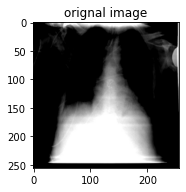

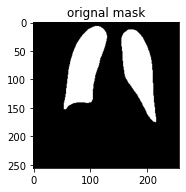

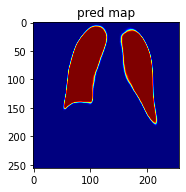

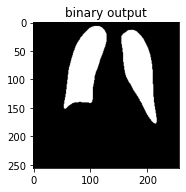

In [46]:
final_image_show = torch.squeeze(final_image).cpu().detach().numpy()
final_image_transpose = np.transpose(final_image_show,(1,2,0))
                                
final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

pred_image_transpose = torch.squeeze(pred).cpu().detach().numpy()
                                
bin_image_transpose = torch.squeeze(pred_score).cpu().detach().numpy()
                                
                                
plt.figure(figsize = (12,4))
plt.subplot(1,4,1)
plt.imshow(final_image_transpose)
plt.title('orignal image')

plt.figure(figsize = (12,4))
plt.subplot(1,4,2)
plt.imshow(final_mask_transpose,cmap = 'gray')
plt.title('orignal mask')

plt.figure(figsize = (12,4))
plt.subplot(1,4,3)
plt.imshow(pred_image_transpose,cmap = 'jet',vmin = 0, vmax = 1)
plt.title('pred map')

plt.figure(figsize = (12,4))
plt.subplot(1,4,4)
plt.imshow(bin_image_transpose,cmap = 'gray')
plt.title('binary output')

In [47]:
# getting the training loss and validation loss graph

In [55]:
%reload_ext tensorboard
%tensorboard --logdir='/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_1/runs'

Reusing TensorBoard on port 6006 (pid 139046), started 0:06:25 ago. (Use '!kill 139046' to kill it.)

In [16]:
total_mean

[129.90850553548862, 129.90850553548862, 129.90850553548862]

In [17]:
total_std

[64.48403222822402, 64.48403222822402, 64.48403222822402]

In [13]:
import pytorch_model_summary as pms

In [14]:
model = Unet(3,1)

In [16]:
print(pms.summary(model, torch.zeros((32, 3, 256, 256)), show_input=True, show_hierarchical=True))

-------------------------------------------------------------------------------------------------
       Layer (type)                                  Input Shape         Param #     Tr. Param #
       DoubleConv-1                            [32, 3, 256, 256]          38,976          38,976
       DownSample-2                           [32, 64, 256, 256]               0               0
       DoubleConv-3                           [32, 64, 128, 128]         221,952         221,952
       DownSample-4                          [32, 128, 128, 128]               0               0
       DoubleConv-5                            [32, 128, 64, 64]         886,272         886,272
       DownSample-6                            [32, 256, 64, 64]               0               0
       DoubleConv-7                            [32, 256, 32, 32]       3,542,016       3,542,016
       DownSample-8                            [32, 512, 32, 32]               0               0
       DoubleConv-9          